In this notebook I will examine the redshift success rates for BGS galaxies at various exposure times observed with nominal dark sky. So far redshift success rate has been assumed to be high for SNR~1 in nominal dark conditions. This is to get an idea of the redshift success rates for various nominal exposure times.

In [41]:
import os 
import h5py 
import numpy as np 
# -- astropy -- 
from astropy.io import fits
from astropy import units as u
# -- desi --
import desisim.simexp
from desispec.io import read_spectra
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM 

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

Lets begin by reading in 3000 BGS galaxies along with their source spectra

In [7]:
dir_spec = '/Users/ChangHoon/data/feasiBGS/bgs_zsuccess'
file_source = 'GALeg.g15.sourceSpec.3000.hdf5'
meta = h5py.File(os.path.join(dir_spec, file_source), 'r') 

# lets recover some metadata
rflux = meta['legacy-photo/flux_r'][...]
b = 1.2e-10
r_mag = -2.5/np.log(10) * (np.arcsinh(1.e-9*rflux/(2.*b)) + np.log(b)) # legacy r magnitude
ztrue = meta['zred'][...] # true redshift

In [8]:
# source wavelength and flux 
w_source = meta['wave'][...] 
f_source = meta['flux'][...]

Text(0.5,1,'source spectra')

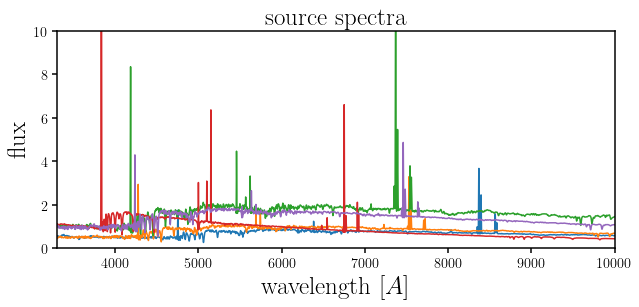

In [31]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(111)
for i in range(5):
    sub.plot(w_source, f_source[i,:])
sub.set_xlabel('wavelength [$A$]', fontsize=25)
sub.set_xlim(3300, 1e4)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(0., 10.)
sub.set_title('source spectra', fontsize=25)

Now lets simulate the exposures with nominal dark sky and different exposure times

In [15]:
texps = [100, 150, 200, 300]

In [21]:
# load in dark sky 
import desimodel.io
params = desimodel.io.load_desiparams()
wavemin = params['ccd']['b']['wavemin']
wavemax = params['ccd']['z']['wavemax']

w_sky = w_source[(w_source >= wavemin) & (w_source <= wavemax)]
config = desisim.simexp._specsim_config_for_wave(w_sky, specsim_config_file='desi')
# load surface brightness dictionary 
surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

# dark sky surface brightness 
dark_sky = surface_brightness_dict['dark'] 

Text(0.5,1,'dark sky brightness')

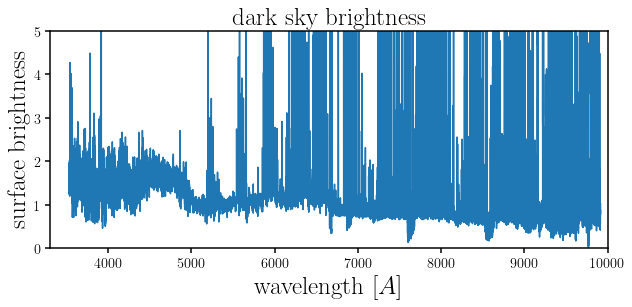

In [25]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(111)
sub.plot(w_sky, dark_sky)
sub.set_xlabel('wavelength [$A$]', fontsize=25)
sub.set_xlim(3300, 1e4)
sub.set_ylabel('surface brightness', fontsize=25)
sub.set_ylim(0., 5.)
sub.set_title("dark sky brightness", fontsize=25)

In [30]:
# simulate the exposures with nominal sky and different t_exp
fdesi = FM.fakeDESIspec()
for texp in texps: 
    file_bgs = os.path.join(dir_spec, file_source.replace('.hdf5', '.nominal_texp%i.fits' % texp))
    
    if not os.path.isfile(file_bgs): 
        print('constructing ... %s' % file_bgs)

        bgs_nom = fdesi.simExposure(w_source, f_source, 
                exptime=texp, 
                airmass=1.,
                seeing=1.1,                                     
                skycondition={'name': 'input', 'sky': np.clip(dark_sky, 0, None), 'wave': w_sky}, 
                filename=file_bgs)
    else: 
        bgs_nom = read_spectra(file_bgs)

constructing ... /Users/ChangHoon/data/feasiBGS/bgs_zsuccess/GALeg.g15.sourceSpec.3000.nominal_texp100.fits
constructing ... /Users/ChangHoon/data/feasiBGS/bgs_zsuccess/GALeg.g15.sourceSpec.3000.nominal_texp150.fits
constructing ... /Users/ChangHoon/data/feasiBGS/bgs_zsuccess/GALeg.g15.sourceSpec.3000.nominal_texp200.fits
constructing ... /Users/ChangHoon/data/feasiBGS/bgs_zsuccess/GALeg.g15.sourceSpec.3000.nominal_texp300.fits


Text(0.5,1,'source spectra')

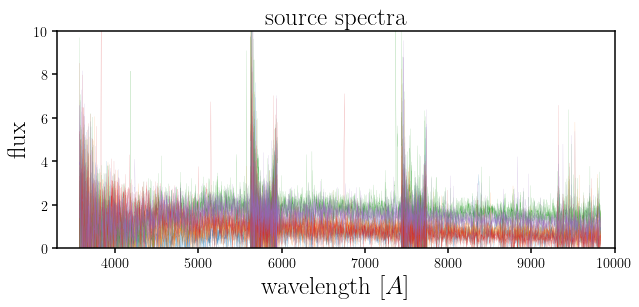

In [38]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(111)
for i in range(5):
    for band in ['b', 'r', 'z']:
        sub.plot(bgs_nom.wave[band], bgs_nom.flux[band][i], c='C%i' % i, lw=0.1)
sub.set_xlabel('wavelength [$A$]', fontsize=25)
sub.set_xlim(3300, 1e4)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(0., 10.)
sub.set_title('source spectra', fontsize=25)

now lets read in redrock outputs which were computed separately on cori

In [55]:
def RR_zsuccess(f_rr, ztrue):     
    ''' return boolean array (True = success; False =fail) from given RR output file (the fits file)
    '''
    rr = fits.open(f_rr)[1].data
    zrr     = rr['Z'] # redrock redshift 
    dchi2   = rr['DELTACHI2']
    zwarn   = rr['ZWARN'] 
    
    return zsuccess(zrr, ztrue, zwarn, deltachi2=dchi2, min_deltachi2=40.)  # min_deltachi2 should be 40 


def zsuccess(zrr, ztrue, zwarn, deltachi2=None, min_deltachi2=40.):
    ''' apply redshift success crition

    |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 

    :params zrr: 
        redrock best-fit redshift

    :params ztrue: 
        true redshift 

    :params zwarn: 
        zwarn flag value 

    :return crit: 
        boolean array indiciate which redshifts were successfully
        measured by redrock 
    '''
    dz_1pz = np.abs(ztrue - zrr)/(1.+ztrue)
    if deltachi2 is None: 
        crit = (dz_1pz < 0.003) & (zwarn == 0)
    else: 
        crit = (dz_1pz < 0.003) & (zwarn == 0) & (deltachi2 > min_deltachi2) 
    return crit

def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate

In [64]:
zsuccesses = [] 
for texp in texps: 
    file_rr = os.path.join(dir_spec, file_source.replace('.hdf5', '.nominal_texp%i.rr.fits' % texp))
    
    if not os.path.isfile(file_rr): 
        print('%s ... does not exist' % os.path.basename(file_rr))
        pass
    else: 
        _zsuccess = RR_zsuccess(file_rr, ztrue)
        zsuccesses.append(_zsuccess)

Text(0.5,1,'Nominal Dark Sky')

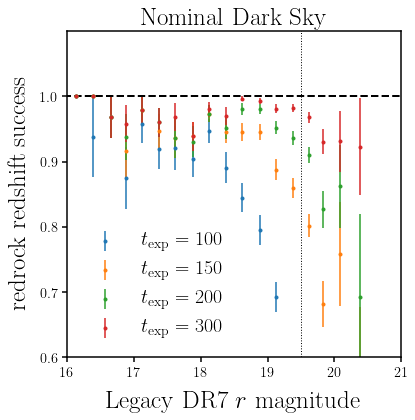

In [65]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
for i, texp, zsucc in zip(range(len(texps)), texps, zsuccesses): 
    wmean, rate, err_rate = zsuccess_rate(r_mag, zsucc, range=[15,22], nbins=28, bin_min=10) 

    sub.errorbar(wmean, rate, err_rate, fmt='.C%i' % i, label=r'$t_{\rm exp} = %i$' % texp)
sub.vlines(19.5, 0., 1.2, color='k', linestyle=':', linewidth=1)
sub.set_xlim([16., 21.]) 
sub.set_ylim([0.6, 1.1])
sub.set_yticks([0.6, 0.7, 0.8, 0.9, 1.]) 
sub.set_xlabel(r'Legacy DR7 $r$ magnitude', labelpad=10, fontsize=25)
sub.set_ylabel(r'redrock redshift success', labelpad=10, fontsize=25)
sub.legend(loc='lower left', fontsize=20)
sub.set_title('Nominal Dark Sky', fontsize=25)